## Public Transportation Analysis
### By: Jayson Shinn

#### I will be using statistical t-tests to determine if cities with public transportation helps to improve a community's economic status. I will be using datasets that contains subway information from New York City and Washington D.C., and demographic data such as education status from both cities. 

In [378]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
from urllib.request import urlopen
import json
import sqlalchemy as sa
import requests  
from urllib.request import urlopen
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


# New York City's Education Stats
url = "https://raw.githubusercontent.com/Jayson257/Public_Transportation_Project/refs/heads/main/export_2025-11-20T15_06_08.273Z.csv"
df_nyc_edu = pd.read_csv(url)

# D.C.'s Education Stats
url2 = "https://raw.githubusercontent.com/Jayson257/Public_Transportation_Project/refs/heads/main/export_2025-11-20T15_04_50.340Z.csv"
df_dc_edu = pd.read_csv(url2)

# New York City's Subway Data
url3 = "https://raw.githubusercontent.com/Jayson257/Public_Transportation_Project/refs/heads/main/trips.txt"
df_nyc_subway = pd.read_csv(url3)

# D.C.'s Metro Data
url4 = "https://raw.githubusercontent.com/Jayson257/Public_Transportation_Project/refs/heads/main/Entries%20by%20Year.csv"
resp = requests.get(url4)

API_KEY = "75d4b21432bb41979feefe6279fb4387"

def api_request():
    url = "https://api.wmata.com/Rail.svc/json/jLines"
    headers = {
        "api_key": API_KEY
    }
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print("Error")
        return None


In [379]:
df_nyc_edu.head()

,Measure,Value,MoE
0,High school or equivalent degree,24.0%,± 0.2%
1,"Some college, no degree",14.1%,± 0.2%
2,Associate's degree,8.7%,± 0.1%
3,Bachelor's degree,22.8%,± 0.2%
4,Graduate or professional degree,18.4%,± 0.2%


In [380]:
df_dc_edu.head()

,Measure,Value,MoE
0,High school or equivalent degree,14.3%,± 1.2%
1,"Some college, no degree",10.2%,± 1.1%
2,Associate's degree,2.0%,± 0.5%
3,Bachelor's degree,27.1%,± 1.3%
4,Graduate or professional degree,38.3%,± 1.4%


In [381]:
df_nyc_subway.head()

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id
0,1,ASP25GEN-1038-Sunday-00_000600_1..S03R,Sunday,South Ferry,1,1..S03R
1,1,ASP25GEN-1038-Sunday-00_002600_1..S03R,Sunday,South Ferry,1,1..S03R
2,1,ASP25GEN-1038-Sunday-00_004600_1..S03R,Sunday,South Ferry,1,1..S03R
3,1,ASP25GEN-1038-Sunday-00_006600_1..S03R,Sunday,South Ferry,1,1..S03R
4,1,ASP25GEN-1038-Sunday-00_007200_1..N03R,Sunday,Van Cortlandt Park-242 St,0,1..N03R


In [382]:
results = api_request()
print(results)

{'Lines': [{'LineCode': 'BL', 'DisplayName': 'Blue', 'StartStationCode': 'J03', 'EndStationCode': 'G05', 'InternalDestination1': '', 'InternalDestination2': ''}, {'LineCode': 'GR', 'DisplayName': 'Green', 'StartStationCode': 'F11', 'EndStationCode': 'E10', 'InternalDestination1': '', 'InternalDestination2': ''}, {'LineCode': 'OR', 'DisplayName': 'Orange', 'StartStationCode': 'K08', 'EndStationCode': 'D13', 'InternalDestination1': '', 'InternalDestination2': ''}, {'LineCode': 'RD', 'DisplayName': 'Red', 'StartStationCode': 'A15', 'EndStationCode': 'B11', 'InternalDestination1': 'A11', 'InternalDestination2': 'B08'}, {'LineCode': 'SV', 'DisplayName': 'Silver', 'StartStationCode': 'N06', 'EndStationCode': 'G05', 'InternalDestination1': '', 'InternalDestination2': ''}, {'LineCode': 'YL', 'DisplayName': 'Yellow', 'StartStationCode': 'C15', 'EndStationCode': 'E06', 'InternalDestination1': 'E01', 'InternalDestination2': ''}]}


In [383]:
dc_metro_df = pd.DataFrame(results)
dc_metro_df.head()

,Lines
0,"{'LineCode': 'BL', 'DisplayName': 'Blue', 'Sta..."
1,"{'LineCode': 'GR', 'DisplayName': 'Green', 'St..."
2,"{'LineCode': 'OR', 'DisplayName': 'Orange', 'S..."
3,"{'LineCode': 'RD', 'DisplayName': 'Red', 'Star..."
4,"{'LineCode': 'SV', 'DisplayName': 'Silver', 'S..."


## Statistical Models

### Test 1: NYC vs. DC Education Rates

In [384]:
df_nyc_clean = df_nyc_edu.copy()
df_dc_clean = df_dc_edu.copy()

df_nyc_clean["Value"] = df_nyc_clean["Value"].str.replace("%","").astype(float)
df_dc_clean["Value"] = df_dc_clean["Value"].str.replace("%","").astype(float)

In [385]:
merged = df_nyc_clean[["Measure", "Value"]].merge(
    df_dc_clean[["Measure", "Value"]],
    on = "Measure",
    suffixes = ("_NYC", "_DC")
)

print(merged)

                            Measure  Value_NYC  Value_DC
0  High school or equivalent degree       24.0      14.3
1           Some college, no degree       14.1      10.2
2                Associate's degree        8.7       2.0
3                 Bachelor's degree       22.8      27.1
4   Graduate or professional degree       18.4      38.3


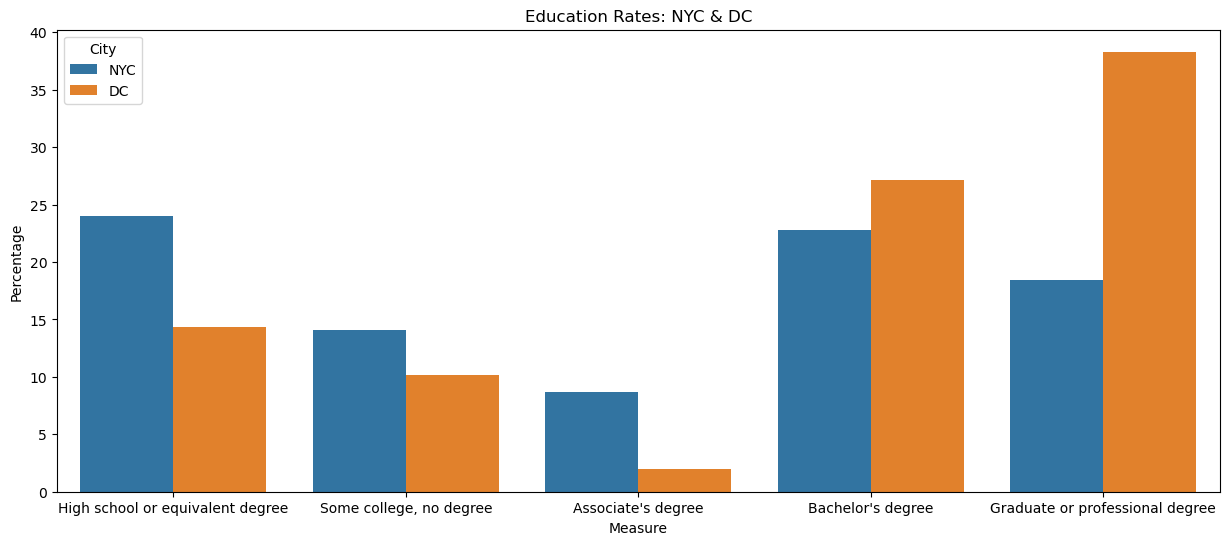

In [386]:
long_df = merged.melt(id_vars = 'Measure', var_name = 'City', value_name = 'Percentage')
long_df['City'] = long_df['City'].replace({'Value_NYC': 'NYC', 'Value_DC': 'DC'})

plt.figure(figsize=(15, 6))
sns.barplot(data=long_df, x='Measure', y='Percentage', hue='City')
plt.title('Education Rates: NYC & DC')
plt.ylabel('Percentage')
plt.show()

In [387]:
t_stat, p_val = stats.ttest_ind(merged["Value_NYC"], merged["Value_DC"])

print("T-Test Comparing NYC and DC Education Rates")
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)

T-Test Comparing NYC and DC Education Rates
T-Statistic:  -0.11115623200990232
P-Value:  0.9142306431739208


#### Analysis: After conducting a simple independent t-test, the p-value came out to be 0.914. Based on this high p-value, the education rates between New York City and D.C. is not statistically significant. This means that we fail to reject the null hypothesis. However, by taking a closer look at the data we can see some slight variations. Some examples include: D.C. has almost double the amount of population with graduate degrees than NYC, and NYC has more of a population with a high school degree than D.C. Overall, despite some of these differences, both cities have a largely educated population and now it's time to test whether public transportation plays a role or not. 

### Test 2: NYC Subway vs. DC Metro Data

In [388]:
# D.C.'s Metro Data
url4 = "https://raw.githubusercontent.com/Jayson257/Public_Transportation_Project/refs/heads/main/Entries%20by%20Year.csv"
resp = requests.get(url4)
print(resp.text[:500])


API_KEY = "75d4b21432bb41979feefe6279fb4387"

def api_request():
    url = "https://api.wmata.com/Rail.svc/json/jLines"
    headers = {
        "api_key": API_KEY
    }
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print("Error")
        return None


	2012	2013	2014	2015	2016	2017	2018	2019	2020	2021	2022	2023	2024	2025
Avg Non-Tapped Entries	0	0	0	0	0	0	0	0	0	0	0	40,919	18,466	20,228
Avg Daily Tapped Entries	702,201	689,949	676,365	657,062	602,459	596,629	588,429	608,984	172,217	133,803	224,599	314,372	376,118	447,161



In [389]:
nyc_subway = pd.DataFrame(df_nyc_subway)
nyc_subway.head()

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id
0,1,ASP25GEN-1038-Sunday-00_000600_1..S03R,Sunday,South Ferry,1,1..S03R
1,1,ASP25GEN-1038-Sunday-00_002600_1..S03R,Sunday,South Ferry,1,1..S03R
2,1,ASP25GEN-1038-Sunday-00_004600_1..S03R,Sunday,South Ferry,1,1..S03R
3,1,ASP25GEN-1038-Sunday-00_006600_1..S03R,Sunday,South Ferry,1,1..S03R
4,1,ASP25GEN-1038-Sunday-00_007200_1..N03R,Sunday,Van Cortlandt Park-242 St,0,1..N03R


#### I am unable to conduct a t-test that compares and anaylzes both cities' subway data. As you can see based on the data, I had trouble with importing all of the data properly. Despite fixing numerous errors and dealing with API issues, I have run out of options for trying to import an accurate amount of data. In addition, I was unable to import actual ridership data from NYC's subway dataset becuase the entire CSV file was 121 Million rows of data and I was unable to access just the ridership data portion of the CSV file. As a result, I am unable to conduct a t-test and I can not determine if there is a statistical relationship or not between ridership data of the two cities. 